# Experiment Analysis

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go

from htc.evaluation.analyze_tfevents import read_tfevent_losses
from htc.evaluation.metrics.scores import normalize_grouped_cm
from htc.models.common.MetricAggregation import MetricAggregation
from htc.settings import settings
from htc.utils.Config import Config
from htc.utils.helper_functions import utilization_table
from htc.utils.LabelMapping import LabelMapping
from htc.utils.sqldf import sqldf
from htc.utils.visualization import (
    create_class_scores_figure,
    create_confusion_figure,
    create_confusion_figure_comparison,
    create_ece_figure,
    create_running_metric_plot,
    create_surface_dice_plot,
    create_training_stats_figure,
    show_class_scores_epoch,
    show_loss_chart,
    visualize_dict,
)

In [2]:
# Parameter for papermill
run_dir = settings.training_dir / "image/2022-01-27_15-52-09_generated_default_lr=0.001"

In [3]:
assert run_dir != "", "No run_dir specified"
if type(run_dir) == str:
    run_dir = Path(run_dir)
print(f"Model: {run_dir.parent.name}")
print(f"Experiment: {run_dir.name}")

Model: image
Experiment: 2022-01-27_15-52-09_generated_default_lr=0.001


In [4]:
# Load training files
df_val = pd.read_pickle(run_dir / "validation_table.pkl.xz").query("dataset_index == 0")
df_train = read_tfevent_losses(run_dir)
config = Config(run_dir / "config.json")
mapping = LabelMapping.from_config(config)

metrics = ["dice_metric"]
if "surface_distance_metric" in df_val:
    metrics.append("surface_distance_metric")

# Aggregated metrics (respecting the hierarchy of the data) with a metric score per subject (due to mode="image_level")
agg = MetricAggregation(df_val, config, metrics=metrics)
df_grouped = agg.grouped_metrics(mode="image_level")

In [5]:
df_train.head()

fold_name  epoch_index  step  lr-Adam  train/ce_loss_step  \
0  fold_P041,P060,P069            0     0  0.00100                 NaN   
1  fold_P041,P060,P069            0    49      NaN            0.925478   
2  fold_P041,P060,P069            0    99      NaN            0.677840   
3  fold_P041,P060,P069            0   100  0.00099                 NaN   
4  fold_P041,P060,P069            1   149      NaN            0.502476   

   train/dice_loss_step  dice_metric  train/ce_loss_epoch  \
0                   NaN          NaN                  NaN   
1              0.716378          NaN                  NaN   
2              0.642946     0.151312             1.192136   
3                   NaN          NaN                  NaN   
4              0.495842          NaN                  NaN   

   train/dice_loss_epoch  
0                    NaN  
1                    NaN  
2               0.770478  
3                    NaN  
4                    NaN

In [6]:
df_val.head()

epoch_index  best_epoch_index  dataset_index            fold_name  \
0            0               100              0  fold_P041,P060,P069   
1            0               100              0  fold_P041,P060,P069   
2            0               100              0  fold_P041,P060,P069   
3            0               100              0  fold_P041,P060,P069   
4            0               100              0  fold_P041,P060,P069   

                 image_name   ce_loss  \
0  P041#2019_12_14_12_00_16  2.176196   
1  P041#2019_12_14_12_01_09  3.329316   
2  P041#2019_12_14_12_01_39  3.734532   
3  P041#2019_12_14_13_33_30  3.563794   
4  P060#2020_05_14_19_14_12  3.071326   

                                    confusion_matrix  \
0  [[89656, 0, 0, 0, 67213, 0, 0, 0, 0, 0, 0, 0, ...   
1  [[68180, 0, 0, 0, 4489, 0, 0, 0, 0, 0, 0, 0, 1...   
2  [[69695, 0, 0, 0, 18283, 0, 0, 0, 0, 0, 0, 0, ...   
3  [[38254, 0, 0, 0, 21136, 0, 0, 0, 0, 0, 0, 0, ...   
4  [[89854, 0, 0, 0, 51314, 0, 0, 0, 0, 0, 0, 0, ...   

                                         dice_metric  dice_metric_image  \
0             [0.7069631, 0.45026344, 0.0, 0.0, 0.0]           0.231445   
1  [0.9279789, 0.0, 0.486868, 0.0, 0.0, 0.0, 0.0,...           0.157205   
2  [0.82159406, 0.0, 0.023540135, 0.0, 0.0, 0.0, ...           0.084513   
3  [0.6365323, 0.29230404, 0.0, 0.0, 0.10245908, ...           0.171883   
4  [0.7598101, 0.0, 0.21599378, 0.0, 0.0, 0.0, 0....           0.121975   

                                                 ece  \
0  {'error': 0.19607168436050415, 'accuracies': [...   
1  {'error': 0.4062032699584961, 'accuracies': [0...   
2  {'error': 0.5549224019050598, 'accuracies': [0...   
3  {'error': 0.4286753535270691, 'accuracies': [0...   
4  {'error': 0.4211149215698242, 'accuracies': [0...   

                          used_labels  
0                    [0, 4, 5, 9, 13]  
1      [0, 3, 4, 5, 6, 7, 10, 11, 13]  
2  [0, 3, 4, 5, 6, 7, 10, 11, 12, 13]  
3                [0, 4, 5, 9, 12, 13]  
4          [0, 3, 4, 5, 6, 7, 10, 11]

In [7]:
df_grouped.head()

subject_name  dice_metric
0         P041     0.909555
1         P044     0.879846
2         P045     0.919605
3         P047     0.883771
4         P048     0.925030

## Config

In [8]:
visualize_dict(config.data)

## Metrics
Visualization of the metrics stored in the TensorBoard events file (everything which is logged via `selg.log()`).

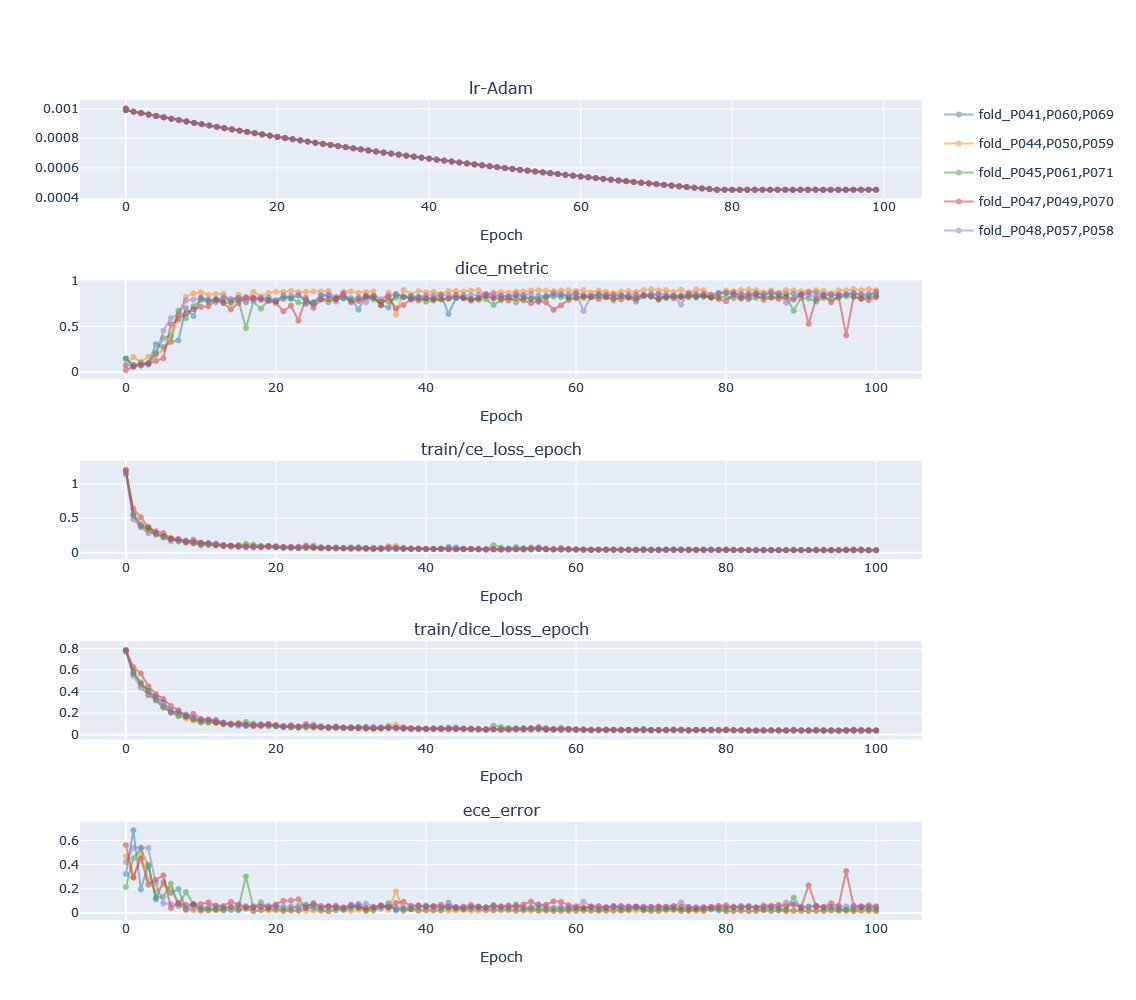

In [9]:
show_loss_chart(df_train, df_val)

For each fold, the current maximum for every epoch of the main metric (the checkpoint metric, `validation/checkpoint_metric` in the config).

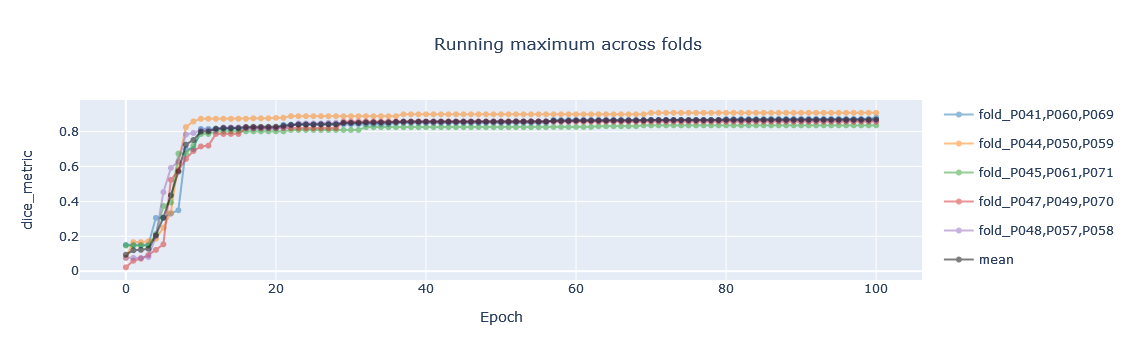

In [10]:
create_running_metric_plot(df_train)

## Training Statistics
The following heatmaps visualize which images the network saw during training. On the $y$-axis is the sorted (by image name) list of images and on the $x$-axis we have the training epochs. For each fold and epoch, we can see how often the network saw a particular image. Usually, we want a random order of images, so if you have the feeling you are looking at a noise image, everything is fine :-)

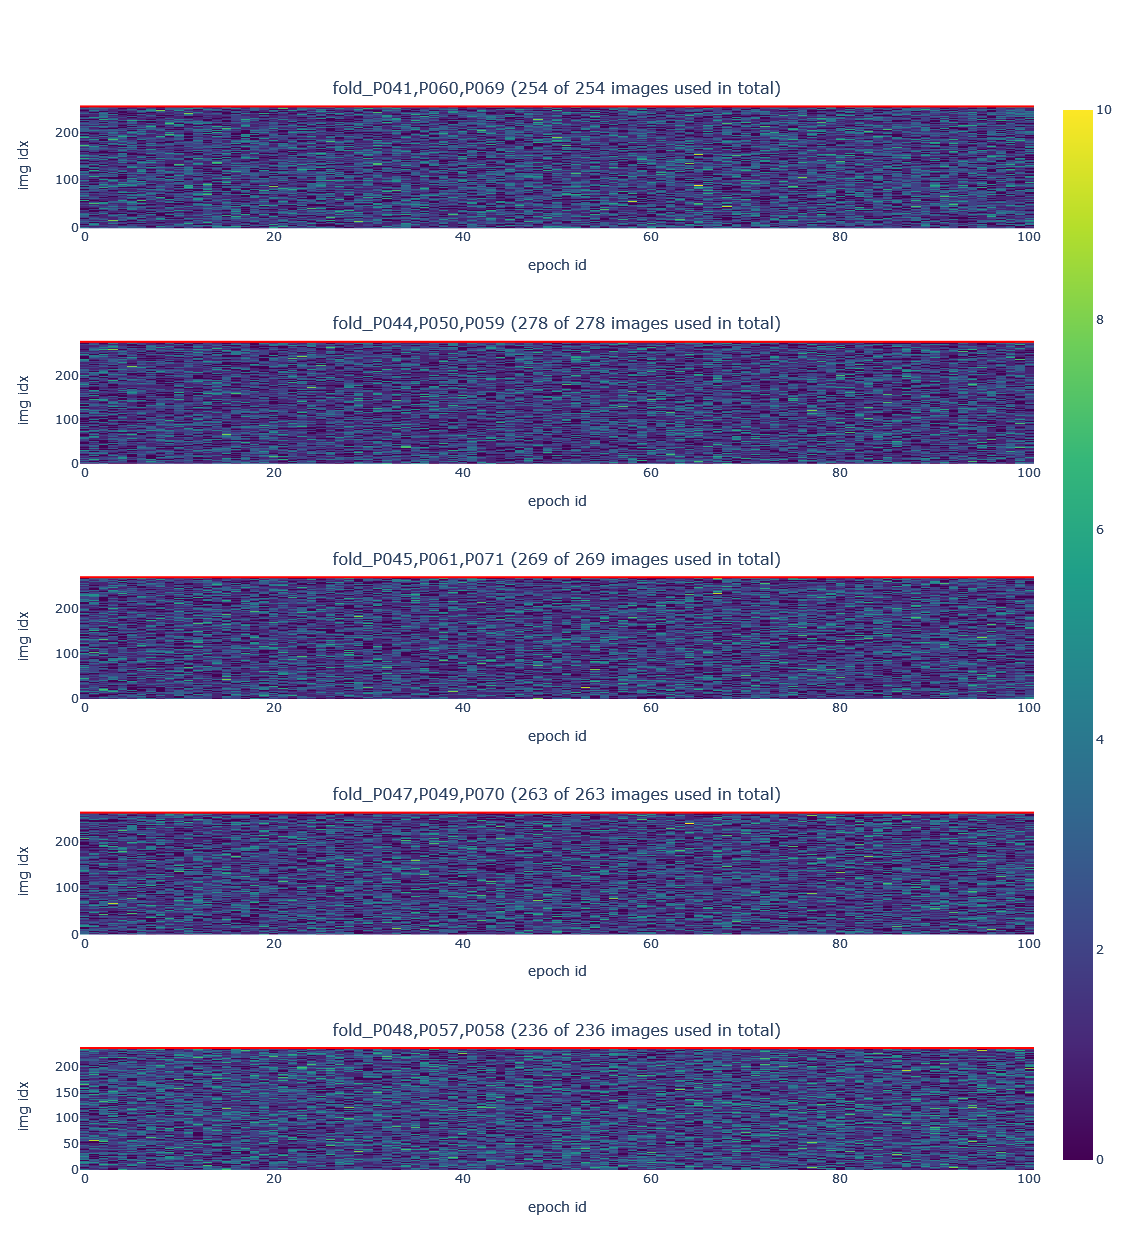

In [11]:
if len(sorted(run_dir.rglob("trainings_stats.npz"))) > 0:
    fig = create_training_stats_figure(run_dir)
    fig.show()

## Hardware Utilization
GPU and CPU utilization for each fold.
> Note: You will only get reasonable numbers if the training was long enough. For super short training times, you might get warnings or nan values

In [12]:
utilization_table(run_dir)

fold         node     hours  gpu_util_mean  gpu_util_std  \
0  fold_P041,P060,P069  hdf19-gpu03  1.961966       0.498409      0.275728   
1  fold_P044,P050,P059   e071-gpu06  1.800125       0.509100      0.355607   
2  fold_P045,P061,P071  hdf19-gpu14  2.065619       0.436366      0.357524   
3  fold_P047,P049,P070   e071-gpu04  1.827570       0.501403      0.342085   
4  fold_P048,P057,P058  hdf19-gpu14  2.260132       0.405431      0.373924   

   cpu_util_mean  cpu_util_std  
0       0.713623      0.112451  
1       0.477692      0.135427  
2       0.732469      0.121587  
3       0.354486      0.118809  
4       0.685695      0.157945

## Best Run

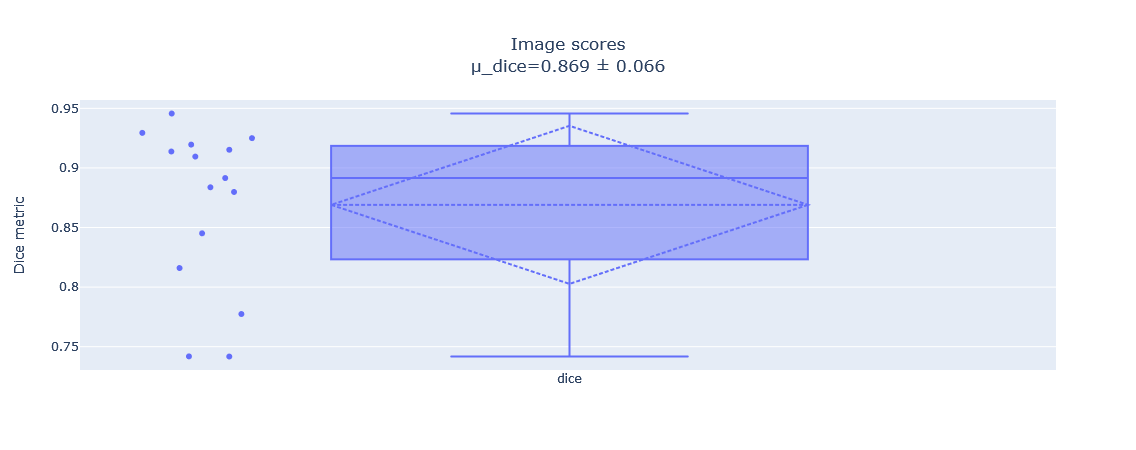

In [13]:
if "surface_distance_metric" in df_grouped:
    fig = create_surface_dice_plot(df_grouped["dice_metric"], df_grouped["surface_distance_metric"])
else:
    fig = go.Figure()
    fig.add_trace(
        go.Box(
            y=df_grouped["dice_metric"],
            text=df_grouped["subject_name"],
            name="dice",
            boxmean="sd",
            boxpoints="all",
        )
    )
    fig.update_layout(
        title_x=0.5,
        title_text=(
            f'Image scores<br>μ_dice={np.mean(df_grouped["dice_metric"]):.03f} ±'
            f' {np.std(df_grouped["dice_metric"]):.03f}'
        ),
    )
    fig.update_yaxes(title_text="Dice metric")
    fig.update_layout(width=500, autosize=False)

fig.show()

In [14]:
df_val_selection = df_val[["epoch_index", "best_epoch_index", "fold_name", "dice_metric_image"]]
sqldf("SELECT DISTINCT fold_name, best_epoch_index FROM df_val_selection ORDER BY best_epoch_index")

fold_name  best_epoch_index
0  fold_P047,P049,P070                29
1  fold_P045,P061,P071                69
2  fold_P048,P057,P058                79
3  fold_P044,P050,P059                99
4  fold_P041,P060,P069               100

## Class Scores (best run)

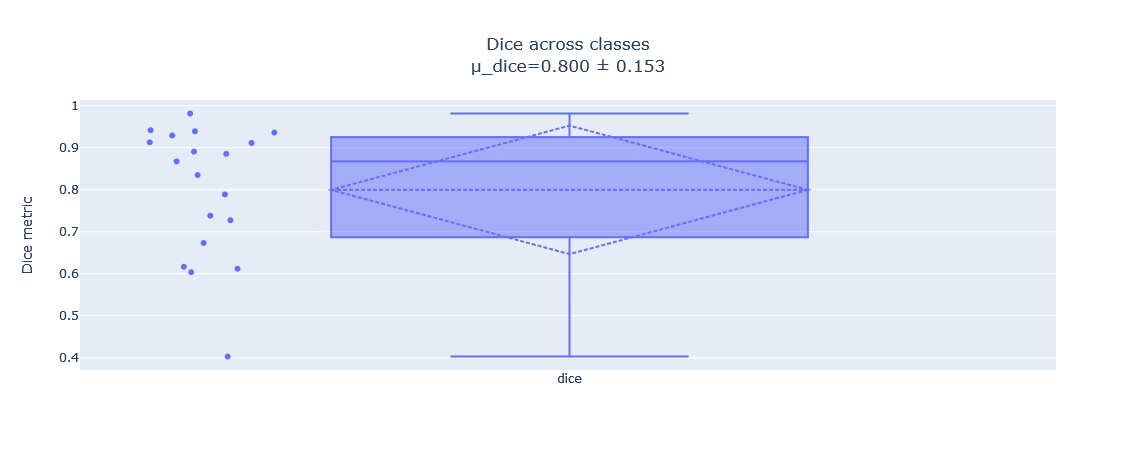

In [15]:
df_label = agg.grouped_metrics()

fig = go.Figure()
fig.add_trace(
    go.Box(y=df_label["dice_metric"], name="dice", boxmean="sd", boxpoints="all", text=df_label["label_name"])
)
fig.update_layout(
    title_x=0.5,
    title_text=(
        f"Dice across classes<br>μ_dice={df_label['dice_metric'].mean():.03f} ± {np.std(df_label['dice_metric']):.03f}"
    ),
)
fig.update_yaxes(title_text="Dice metric")
fig.update_layout(width=500, autosize=False)

Comparison of class dice scores. Each boxplot shows the distribution of dice values across subjects. The image and pixel counts are the sum over all images in the validation sets.

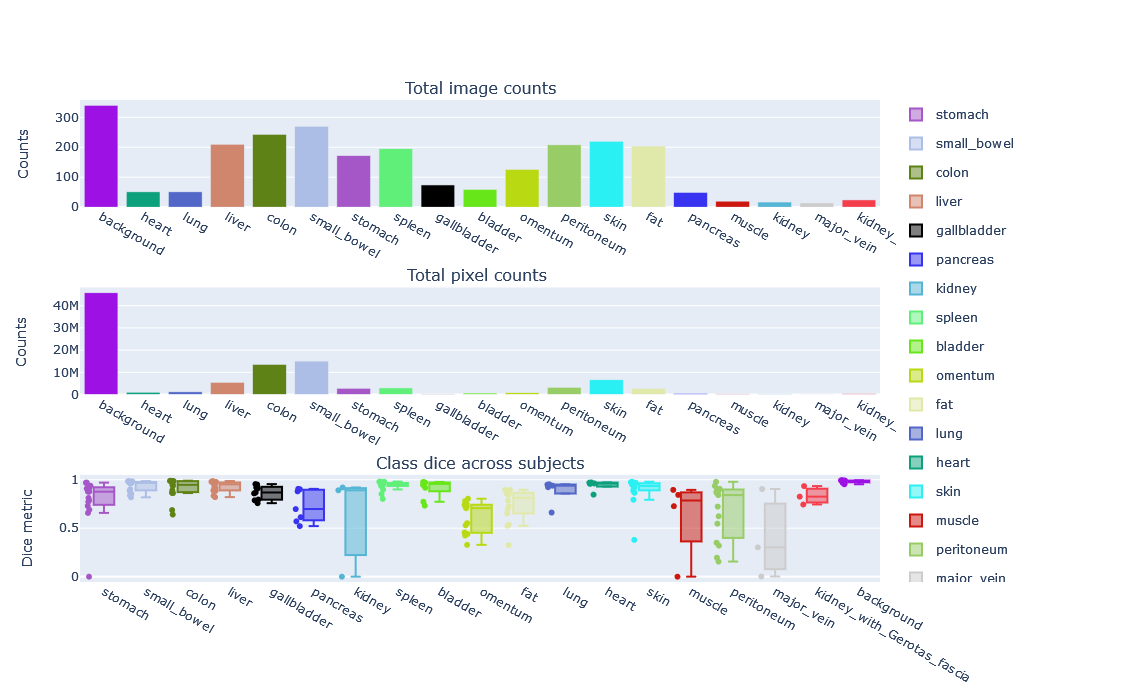

In [16]:
if "confusion_matrix" in df_val:
    create_class_scores_figure(agg)

## Class Imbalances (training time)

[WARNING][py.warnings] /mnt/ssd_8tb/htc/src/htc/utils/visualization.py:614: FutureWarning:               warnings.py:109
                                                                                                                        
The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version,                          
numeric_only will default to False. Either specify numeric_only or select only columns which should be                  
valid for the function.                                                                                                 
                                                                                                                        
                                                                                                                        

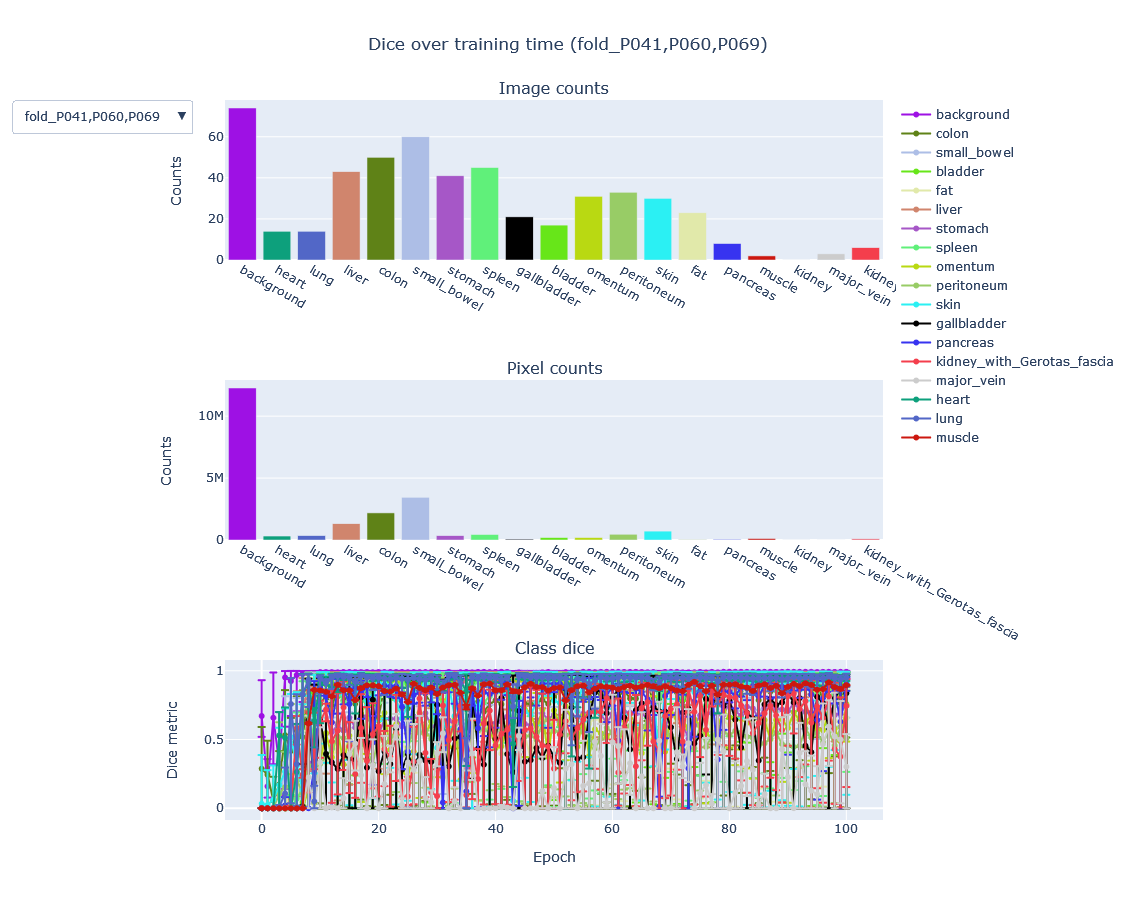

In [17]:
if "confusion_matrix" in df_val:
    show_class_scores_epoch(df_val, mapping)

## Confusion Matrix (best run)
Normalized confusion matrix. For each row, you can see how many of the annotated images were classified to the respective class.

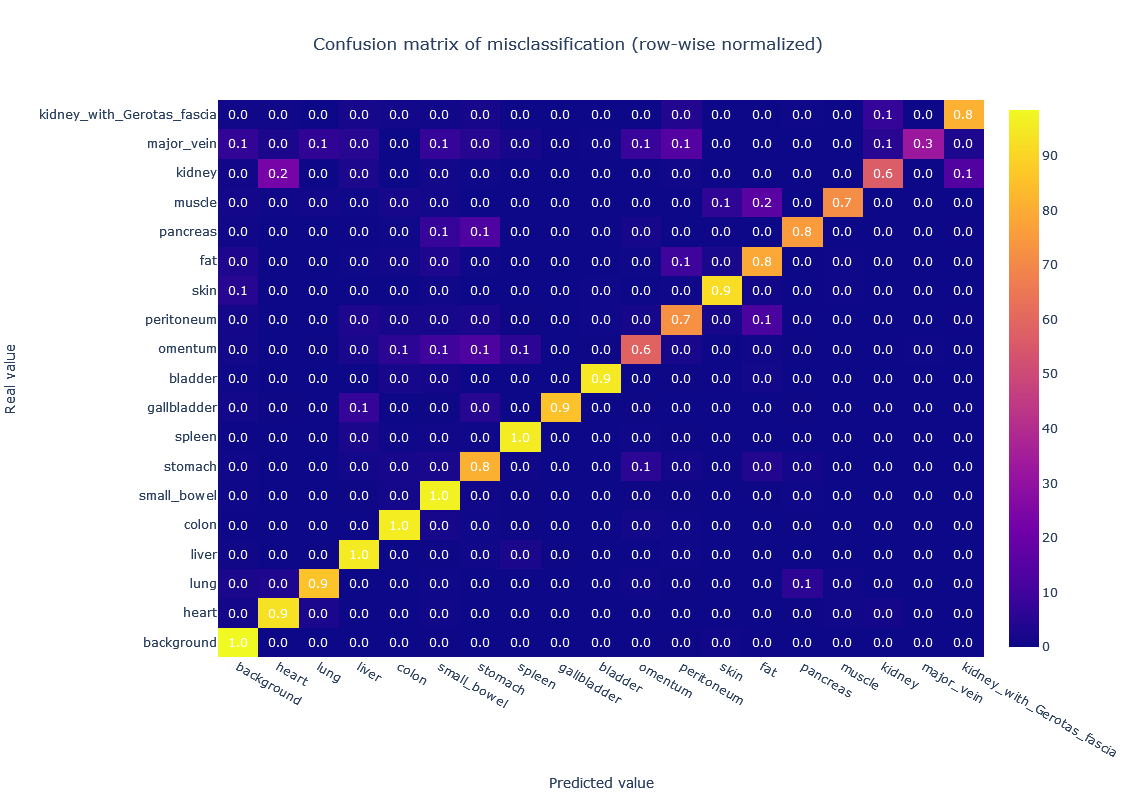

In [18]:
if "confusion_matrix" in df_val:
    cm_rel, cm_std = normalize_grouped_cm(np.stack(agg.grouped_cm()["confusion_matrix"].values))
    create_confusion_figure(cm_rel, labels=mapping.label_names()).show()

## ECE Error (best run)

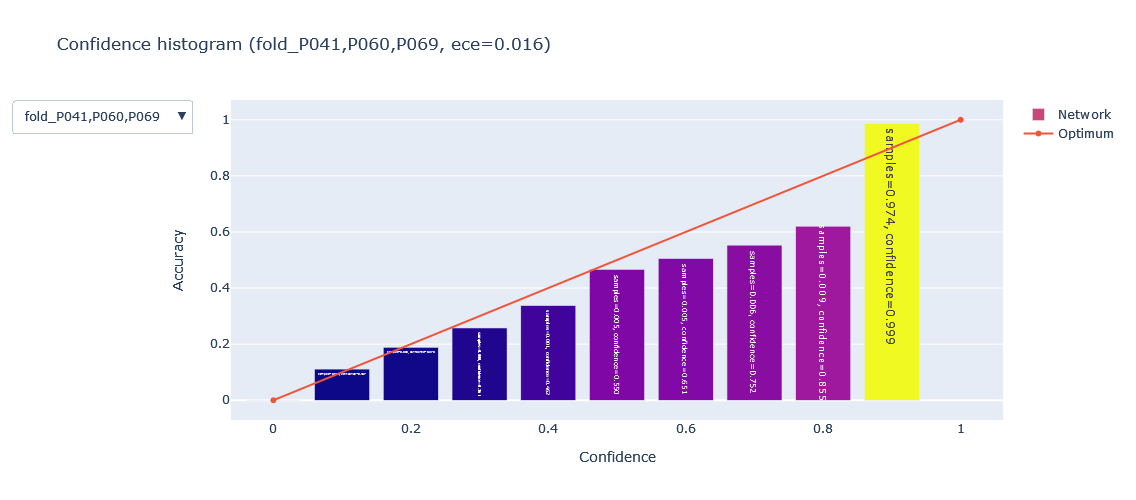

In [19]:
if "ece" in df_val:
    create_ece_figure(df_val).show()

In [20]:
compare_run_dir = None
# compare_run_dir = settings.training_dir / 'pixel/pixel_model_humans+pigs_pretrained'

In [21]:
if compare_run_dir is not None:
    df_val_compare = pd.read_pickle(compare_run_dir / "validation_table.pkl.xz").query("dataset_index == 0")
    df_train_compare = read_tfevent_losses(compare_run_dir)

    metrics_compare = ["dice_metric", "dice_metric_image"]
    if "confusion_matrix" in df_val_compare:
        metrics_compare.append("confusion_matrix")
    if "surface_distance_metric_image" in df_val_compare:
        metrics_compare.append("surface_distance_metric_image")

    config_compare = Config(compare_run_dir / "config.json")
    mapping_compare = LabelMapping.from_config(config_compare)

    if "confusion_matrix" in df_val_compare:
        cm = MetricAggregation(compare_run_dir).grouped_cm()["confusion_matrix"]
        cm_rel_compare, cm_std_compare = normalize_grouped_cm(np.stack(cm.values))

        create_confusion_figure_comparison(
            cm_rel,
            cm_rel_compare,
            str(run_dir).split("/")[-1],
            str(compare_run_dir).split("/")[-1],
            labels=mapping_compare.label_names(),
        ).show()